<h1> Regional malaria data with monthly weather information </h1>

In [24]:
from __future__ import division

import datetime
import json
import numpy as np
import pandas as pd
import seaborn as sns
import psycopg2

from ethiopian_date import ethiopian_date
from scipy import interpolate
from scipy.signal import savgol_filter

%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<h1> constants </h1>

In [25]:
START_DATE = '2014-07-01'

<h1> Functions </h1>

In [26]:
def set_to_first_of_month(Date):
    return datetime.date(Date.year, Date.month, 1)

def make_edate(date):
    '''If 13th month we move forward 6 days to avoid error. The 13th month is lumped in with the 1st month'''
    try:
        return ethiopian_date.EthiopianDateConverter.date_to_ethiopian(date)
    except ValueError:
        return ethiopian_date.EthiopianDateConverter.date_to_ethiopian(date + pd.offsets.relativedelta(days=6))
    
def interpolate_between_dates(interp_date, region, yearly_pop):
    ''' Linear interpolation between dates 
        Input a single date and region 
        The yearly_pop data frame needs to have E_Date as the index'''
    #interp_dates = pd.DatetimeIndex(interp_dates)
    x_data = yearly_pop.loc[region].val.index
    y_data = yearly_pop.loc[region].val.values
    
    epoch = x_data[0]
    x_data = (x_data - epoch).total_seconds()
    interp_date = (interp_date - epoch).total_seconds()

    # Do a linear interpolation if outside of the range
    interp_fun = interpolate.interp1d(x_data, y_data, fill_value = "extrapolate")
    return int(interp_fun(interp_date))


<h1> Connect to psql DB and return the monthly weather dataframe </h1>

In [27]:
conn = psycopg2.connect("host=localhost port=5432 dbname=et_weather user=attiladobi")
cur = conn.cursor()

sql_query = 'SELECT * FROM monthly;'
monthly_weather = pd.read_sql_query(sql_query, conn)

monthly_weather['Real_Date'] = [ethiopian_date.EthiopianDateConverter.date_to_gregorian(date) \
                                for date in monthly_weather['e_date']]
conn.close()

monthly_weather.rename(columns={'geokey': 'GeoKey'}, inplace=True)
# convert to datetime64
monthly_weather['e_date'] = monthly_weather['e_date'].astype(datetime64)
monthly_weather['RegionKey'] = monthly_weather['GeoKey'].apply(lambda x: '%s______' % x.split('__')[0])

# Group by regions and compute averages
monthly_weather= monthly_weather.groupby(['RegionKey', 'e_date']).mean().reset_index()

monthly_weather.tail()

RegionKey     e_date  precipitation  max_precipitation  \
589  tigray______ 2009-05-01       2.798253           1.660447   
590  tigray______ 2009-06-01      28.802365          12.766595   
591  tigray______ 2009-07-01       7.012120           3.139087   
592  tigray______ 2009-08-01      45.998654          13.531955   
593  tigray______ 2009-09-01      72.987389          20.069938   

     days_precipitation  wind_avg   temp_max   temp_min   temp_avg  humid_max  \
589            1.695652  3.845090  26.830218  10.866739  19.407308  82.155870   
590            7.608696  4.729153  26.869348  12.523043  19.552830  79.590652   
591            3.434783  3.856473  29.884565  13.334783  21.620562  79.533913   
592           11.630435  2.990693  32.970287  13.949566  22.454698  72.342392   
593           12.500000  3.524683  29.728696  15.468696  22.556709  86.483261   

     humid_min  humid_avg        solar  
589   2.669348  42.221464  5786.793949  
590   4.858261  43.861475  6497.133262  
591   4.543913  38.916391  7674.475533  
592   2.825870  34.323674  7139.399912  
593   7.475217  43.013854  6421.765410

<h1> Load indicator ID mapping </h1>

In [28]:
import sys
sys.path.append('/Users/attiladobi/zenysis')
import config.et.indicators
IDlookup = {val['id']:val for cluster in config.et.indicators.GROUP_DEFINITIONS for val in cluster['indicators']}

<h1> Load in region level malaria data </h1>

In [29]:
# Replace with direct druid query. Use example file for now.
with open('/Users/attiladobi/Downloads/2017-05-31_malaria_data.json', 'rb') as f:
    data = f.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF2 = pd.read_json(data_json_str)

In [30]:
df_list = []
for region in DF2['byGeo'][0].keys():
    region_name = region.split('_')[0]
    meta_data = pd.DataFrame(DF2['byGeo'][0][region]['data']['month'])
    formatted_data = pd.DataFrame(meta_data[1:].stack()).reset_index(level=0)
    formatted_data.index = [pd.to_datetime(val) for val in formatted_data.index]
    formatted_data.columns = ['Indicator_id', 'val']
    formatted_data.index.name = 'Real_Date'
    formatted_data['Region'] = region_name
    # Drop data that doesn't have indicator information. They start with Real_Date
    formatted_data = formatted_data[formatted_data['Indicator_id'] != 'Real_Date']
    df_list.append(formatted_data)
DF_ind=pd.concat(df_list)
DF_ind['Indicator'] = [IDlookup[val]['text'] for val in DF_ind['Indicator_id']]
# enfore data type for aggregations
DF_ind['val'] = DF_ind['val'].astype('float')

# Data starts after 2014-07-01
DF_ind= DF_ind[DF_ind.index > pd.to_datetime(START_DATE)]

#Note: region_name, zone_name, woreda_name are all lower case

In [31]:
DF_ind.columns

Index([u'Indicator_id', u'val', u'Region', u'Indicator'], dtype='object')

<h1> Label gender, age and inferction catagories </h1>

In [32]:
# Indicators used for fitting
ind_total = 'Number of slides or RDT positive for malaria'
ind_f_5 = 'Number of slides or RDT positive for malaria < 5 years: Females'
ind_m_5 = 'Number of slides or RDT positive for malaria < 5 years: Males'
ind_f_5_14 = 'Number of slides or RDT positive for malaria 5-14 years: Females'
ind_m_5_14 = 'Number of slides or RDT positive for malaria 5-14 years: Males'
ind_f_15_up = 'Number of slides or RDT positive for malaria >=15 years: Females'
ind_m_15_up = 'Number of slides or RDT positive for malaria >=15 years: Males'

ind_names = [ind_total, ind_f_5, ind_m_5, ind_f_5_14, ind_m_5_14, ind_f_15_up, ind_m_15_up]
ind_age_cat = [4, 1, 1, 2, 2, 3, 3]
ind_gender_cat = [3, 2, 1, 2, 1, 2, 1]
name_to_gen_age_map = {ind_name: (gender, age) for ind_name, gender, age in zip(ind_names, ind_gender_cat, ind_age_cat)}

def lookup_gen_age(ind_name):
    keys = ('gender', 'age')
    if ind_name in name_to_gen_age_map:
        return dict(zip(keys, name_to_gen_age_map[ind_name]))
    else:
        return dict(zip(keys, (0, 0)))
    
def is_male(ind_name):
    return 1 if (lookup_gen_age(ind_name)['gender'] == 1) else 0
def is_child(ind_name):
    return 1 if (lookup_gen_age(ind_name)['age'] == 1) else 0
def is_teen(ind_name):
    return 1 if (lookup_gen_age(ind_name)['age'] == 2) else 0

def is_male_child(is_male, is_child, is_teen):
    return 1 if (is_male and is_child) else 0
def is_female_child(is_male, is_child, is_teen):
    return 1 if (not is_male and is_child) else 0
def is_male_teen(is_male, is_child, is_teen):
    return 1 if (is_male and is_teen) else 0
def is_female_teen(is_male, is_child, is_teen):
    return 1 if (not is_male and is_teen) else 0
def is_male_adult(is_male, is_child, is_teen):
    return 1 if (is_male and not is_teen and not is_child) else 0

# Check if the inficetion rate in the region is high (on average over 1000 per month)
mean_monthly_total = DF_ind[DF_ind['Indicator']==ind_total].groupby(['Region']).val.mean()
is_high_list = mean_monthly_total[mean_monthly_total > 1000].index

DF_ind['is_male'] = [is_male(ind_name) for ind_name in DF_ind['Indicator']]
DF_ind['is_child'] = [is_child(ind_name) for ind_name in DF_ind['Indicator']]
DF_ind['is_teen'] = [is_teen(ind_name) for ind_name in DF_ind['Indicator']]


DF_ind['is_male_child'] = (DF_ind['is_male'].astype(bool)  & DF_ind['is_child'].astype(bool)).astype(int)
DF_ind['is_female_child'] = (~DF_ind['is_male'].astype(bool)  & DF_ind['is_child'].astype(bool)).astype(int)
DF_ind['is_male_teen'] = (DF_ind['is_male'].astype(bool)  & DF_ind['is_teen'].astype(bool)).astype(int)
DF_ind['is_female_teen'] = (~DF_ind['is_male'].astype(bool)  & DF_ind['is_teen'].astype(bool)).astype(int)
DF_ind['is_male_adult'] = (DF_ind['is_male'].astype(bool)  & ~DF_ind['is_teen'].astype(bool) \
                         & ~DF_ind['is_child'].astype(bool)).astype(int)

DF_ind['rate_is_high'] = [1 if region in is_high_list else 0 for region in DF_ind['Region']]


<h1> Add Ethiopian dates </h1>

In [33]:
e_dates = []
for date in DF_ind.index:
    ''' Except error if we land in the 13th month. Shift the date by 6 days'''
    try:
        e_dates.append(make_edate(date))
    except ValueError:
        e_dates.append(make_edate(date))
DF_ind['E_Date'] = [set_to_first_of_month(date) for date in e_dates] # another patch for the 13th month
DF_ind['E_Date'] = DF_ind['E_Date'].astype(datetime64)
DF_ind['E_year'] = [val.year for val in DF_ind['E_Date']]
DF_ind['E_month'] = [val.month for val in DF_ind['E_Date']]
DF_ind['month'] = DF_ind.index.month
DF_ind['year'] = DF_ind.index.year
DF_ind.reset_index(inplace=True)
DF_ind.head()

Real_Date            Indicator_id  val Region                  Indicator  \
0 2014-07-08  TargetPopulationFemale  0.0   afar  Target Population Females   
1 2014-08-07  TargetPopulationFemale  0.0   afar  Target Population Females   
2 2014-09-06  TargetPopulationFemale  0.0   afar  Target Population Females   
3 2014-10-11  TargetPopulationFemale  0.0   afar  Target Population Females   
4 2014-11-10  TargetPopulationFemale  0.0   afar  Target Population Females   

   is_male  is_child  is_teen  is_male_child  is_female_child  is_male_teen  \
0        0         0        0              0                0             0   
1        0         0        0              0                0             0   
2        0         0        0              0                0             0   
3        0         0        0              0                0             0   
4        0         0        0              0                0             0   

   is_female_teen  is_male_adult  rate_is_high     E_Date  E_year  E_month  \
0               0              0             1 2006-11-01    2006       11   
1               0              0             1 2006-12-01    2006       12   
2               0              0             1 2007-01-01    2007        1   
3               0              0             1 2007-02-01    2007        2   
4               0              0             1 2007-03-01    2007        3   

   month  year  
0      7  2014  
1      8  2014  
2      9  2014  
3     10  2014  
4     11  2014

<h1> Group population data by Ethiopian year </h1>

In [34]:
population_data = DF_ind[DF_ind['Indicator']=='Population'].reset_index()
population_data['val'] = population_data.val.astype(float)
yearly_pop = population_data.groupby(['Region', population_data['E_Date'].map(lambda x: x.year)]).val.mean()
yearly_pop = yearly_pop.reset_index()
yearly_pop['E_Date'] = pd.to_datetime(yearly_pop['E_Date'], format='%Y')
yearly_pop.set_index(['Region', 'E_Date'], inplace=True)
#yearly_pop

In [35]:
yearly_pop.head()

val
Region      E_Date                  
addis ababa 2006-01-01  3.352000e+06
            2007-01-01  3.352000e+06
            2008-01-01  3.365667e+06
            2009-01-01  3.433999e+06
afar        2006-01-01  2.027466e+06

<h1> Add population data for every E_Date in the dateframe </h1>

In [36]:
DF_ind['pop'] = [interpolate_between_dates(edate, region, yearly_pop) for edate, region in DF_ind[['E_Date', 'Region']].values]

<h1> Plot the interpolation of population for all regions </h1>

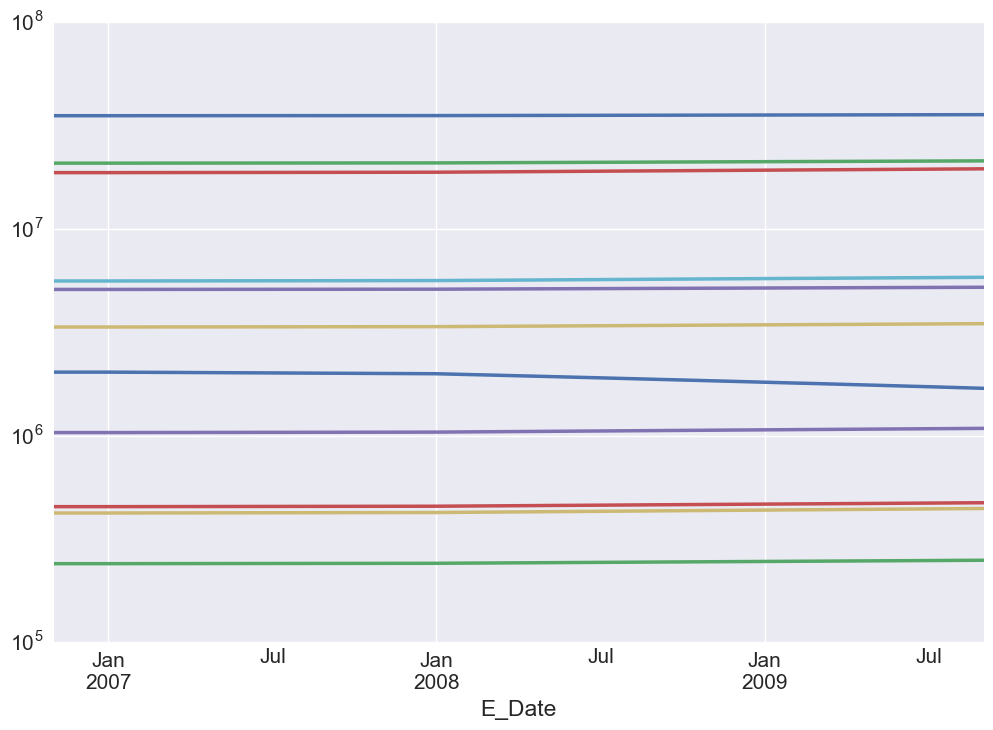

In [37]:
regions = DF_ind['Region'].unique()
for region in regions:
    DF_ind.groupby(['Region', 'E_Date']).pop.mean().loc[region].plot()
yscale('log')

<h1> Add GeoKey to the dataframe </h1>

In [38]:
GEO_COLS = ['Region', 'Zone', 'Woreda']
name_cols = [column for column in DF_ind.columns if column in GEO_COLS]
end_dash = '__' * (4 - len(name_cols))
DF_ind['GeoKey'] = DF_ind[name_cols].apply(lambda x: '%s%s' % ('__'.join(x).lower(), end_dash), axis=1)
    
DF_ind['RegionKey'] = DF_ind['Region'].apply(lambda x: '%s______' % x.split('__')[0])

<h1> Load in the region_info.csv file for area and elevation </h1>

In [39]:
region_info = pd.read_csv('/Users/attiladobi/PyNotebooks/zenysis/mapped_info/region_info.csv')

<h1> Add region info to the DF by joining </h1>

In [40]:
DF_ind = DF_ind.merge(region_info, on='GeoKey', how='inner')
DF_ind['density'] = DF_ind['pop'] / DF_ind['Area_km2']
DF_ind['infection_rate'] = DF_ind['val'] / DF_ind['pop'] #only applies to one indicator: indicator = 'Number of slides or RDT positive for malaria'


<h1> Add total number of RTDs </h1>

In [41]:
rdt_total = 'Total number of slides or RDT performed for malaria diagnosis'
malaria_tests = DF_ind.loc[DF_ind['Indicator']==rdt_total][['GeoKey', 'E_Date', 'val']]
malaria_tests.rename(columns={'val': 'RDT_total'}, inplace=True)
DF_ind = DF_ind.merge(malaria_tests, on=['E_Date', 'GeoKey'], how='left')


<h1> Add insecticide net fraction data </h1> 

In [42]:
indicator = 'Number of slides or RDT positive for malaria'
DF_mean = DF_ind.loc[DF_ind['Indicator']==indicator].groupby('Region').mean()

ind_nets = 'Proportion of targeted HH covered with LLIN in the last 12 months'
DF_mean_nets = DF_ind.loc[DF_ind['Indicator']==ind_nets].groupby('Region').mean()
#add back Addis info:
DF_mean_nets.loc['addis ababa'] =  DF_mean_nets.loc['oromiya']
DF_ind['net_frac'] = [DF_mean_nets.val[region] for region in DF_ind['Region']]


<h1> Add average monthly weather data. Along with shifted values </h1>

In [63]:
monthly_weather

RegionKey     e_date  precipitation  max_precipitation  \
0    addis ababa______ 2005-04-01       2.065414           0.786827   
1    addis ababa______ 2005-05-01       6.054673           0.823472   
2    addis ababa______ 2005-06-01       5.302964           0.754839   
3    addis ababa______ 2005-07-01      29.403148           9.581333   
4    addis ababa______ 2005-08-01      33.965273          19.818000   
5    addis ababa______ 2005-09-01       8.708039           2.694935   
6    addis ababa______ 2005-10-01     111.105418          22.348001   
7    addis ababa______ 2005-11-01     149.828294          26.328332   
8    addis ababa______ 2005-12-01     126.504875          26.645999   
9    addis ababa______ 2006-01-01      16.467963           1.916938   
10   addis ababa______ 2006-02-01       9.457373           1.355297   
11   addis ababa______ 2006-03-01       5.244331           0.718738   
12   addis ababa______ 2006-04-01       7.128302           0.920018   
13   addis ababa______ 2006-05-01       7.051911           1.302355   
14   addis ababa______ 2006-06-01      29.689909          23.355501   
15   addis ababa______ 2006-07-01      10.953550           2.413854   
16   addis ababa______ 2006-08-01      17.454237           8.844167   
17   addis ababa______ 2006-09-01      35.956403           9.965500   
18   addis ababa______ 2006-10-01      46.887245          18.239333   
19   addis ababa______ 2006-11-01      95.885615          29.583001   
20   addis ababa______ 2006-12-01     195.230403          30.037334   
21   addis ababa______ 2007-01-01      87.000108          16.910999   
22   addis ababa______ 2007-02-01      30.369186           4.714893   
23   addis ababa______ 2007-03-01      37.949178           4.728004   
24   addis ababa______ 2007-04-01      11.260855           1.466501   
25   addis ababa______ 2007-05-01      19.112046           2.443343   
26   addis ababa______ 2007-06-01      19.193821           3.762707   
27   addis ababa______ 2007-07-01      21.360523           6.833222   
28   addis ababa______ 2007-08-01      19.438735           6.724659   
29   addis ababa______ 2007-09-01      27.623589           9.372590   
..                 ...        ...            ...                ...   
564       tigray______ 2007-04-01       0.371739           0.204783   
565       tigray______ 2007-05-01       4.895870           2.697391   
566       tigray______ 2007-06-01       5.253261           3.285978   
567       tigray______ 2007-07-01      33.129783          13.931739   
568       tigray______ 2007-08-01      36.636196          18.823370   
569       tigray______ 2007-09-01      26.205652           9.476739   
570       tigray______ 2007-10-01      41.765869          13.438369   
571       tigray______ 2007-11-01     165.230544          31.124674   
572       tigray______ 2007-12-01     200.638075          33.987065   
573       tigray______ 2008-01-01      46.951435          16.410878   
574       tigray______ 2008-02-01      17.567609           7.780435   
575       tigray______ 2008-03-01       7.008173           5.277596   
576       tigray______ 2008-04-01      24.153988          16.880562   
577       tigray______ 2008-05-01       0.365406           0.305720   
578       tigray______ 2008-06-01       4.678950           2.574420   
579       tigray______ 2008-07-01      25.723387          12.891651   
580       tigray______ 2008-08-01      42.934558          11.281126   
581       tigray______ 2008-09-01      25.705282          12.035166   
582       tigray______ 2008-10-01     100.427881          23.753814   
583       tigray______ 2008-11-01     248.018670          51.082448   
584       tigray______ 2008-12-01     141.429010          26.886782   
585       tigray______ 2009-01-01      79.773550          22.439546   
586       tigray______ 2009-02-01      20.076803          11.562208   
587       tigray______ 2009-03-01       4.794491           3.404711   
588       tigray______ 2009-04-01    

In [43]:
# This limits malaria forecasting to N-3 months. (since it uses info from the past four months)
N = 8
for i in range(0, N):
    # if first one, skip the suffix (left, right)
    suffixes = ('', '') if i==0 else ('', '_shift_%s' % i)
    # Keep with convention of value reporting. First of month is for averages of the previous month
    monthly_weather['E_Date'] = [date + pd.offsets.relativedelta(months=i) for date in monthly_weather['e_date']]
    # Merge onto original dataframe, ignore e_date column that represents monthly grouping
    DF_ind = DF_ind.merge(monthly_weather.drop('e_date', axis=1), on=['E_Date', 'RegionKey'], how='left', suffixes=suffixes)
DF_ind.head()

Real_Date            Indicator_id  val Region                  Indicator  \
0 2014-07-08  TargetPopulationFemale  0.0   afar  Target Population Females   
1 2014-08-07  TargetPopulationFemale  0.0   afar  Target Population Females   
2 2014-09-06  TargetPopulationFemale  0.0   afar  Target Population Females   
3 2014-10-11  TargetPopulationFemale  0.0   afar  Target Population Females   
4 2014-11-10  TargetPopulationFemale  0.0   afar  Target Population Females   

   is_male  is_child  is_teen  is_male_child  is_female_child      ...        \
0        0         0        0              0                0      ...         
1        0         0        0              0                0      ...         
2        0         0        0              0                0      ...         
3        0         0        0              0                0      ...         
4        0         0        0              0                0      ...         

   max_precipitation_shift_7  days_precipitation_shift_7  wind_avg_shift_7  \
0                   2.975365                     1.81250          3.441196   
1                   1.339688                     1.06250          4.607471   
2                   1.690469                     1.03125          4.684676   
3                   4.297604                     2.81250          4.738805   
4                  31.871721                     8.06250          3.853319   

   temp_max_shift_7 temp_min_shift_7  temp_avg_shift_7  humid_max_shift_7  \
0         35.240000        18.191250         26.527832         100.000000   
1         31.729375        17.376563         24.968401          73.876250   
2         35.016875        18.146875         25.579599          74.406250   
3         32.710000        19.617813         26.310323          83.578750   
4         35.167188        21.667500         28.155510          89.294063   

   humid_min_shift_7  humid_avg_shift_7  solar_shift_7  
0          10.336562          49.590918    3503.371445  
1           0.000000          30.050594    4101.411901  
2           0.238437          24.762885    4116.578617  
3           3.816875          43.337208    5208.527567  
4          13.656250          46.343120    5095.890343  

[5 rows x 123 columns]

In [62]:
DF_ind[['precipitation']]

precipitation
0          9.524636
1        108.096564
2        130.982240
3        108.664218
4          7.708594
5          9.853125
6         18.025313
7         14.761875
8         16.210312
9         52.935000
10        48.239063
11        32.943750
12        10.246875
13        70.160157
14       133.279219
15        44.039063
16         5.677500
17         6.153750
18         8.600916
19         3.858574
20        22.878745
21        42.091917
22       152.777402
23        23.206558
24        27.702808
25       203.052419
26        95.202226
27        35.947485
28         2.159846
29        19.479632
...             ...
6900      57.707143
6901       5.762143
6902       3.540000
6903      25.444286
6904      88.759286
6905     128.833929
6906     208.338215
6907     152.493215
6908     187.883571
6909     144.751072
6910     159.877499
6911     151.174285
6912      61.699285
6913      12.140747
6914       2.429471
6915      10.347694
6916      53.190178
6917     170.041910
6918     225.961912
6919     186.276776
6920     206.319795
6921     132.913830
6922     194.996296
6923      97.118817
6924      23.106201
6925       6.077958
6926       5.542026
6927      30.928082
6928      73.186829
6929     200.551409

[6930 rows x 1 columns]

<h3> black magic to remove Nulls from wind_avg data in trigray and replace them with the following year's value </h3>

In [44]:
# Following format: df.loc[(df['column1'] == some_value) & (df['column2'] == some_other_value), ['column_to_change']] = new_value
monthly_weather.loc[(monthly_weather['wind_avg'].isnull()), ['wind_avg']] = \
[monthly_weather.loc[(monthly_weather['RegionKey']==region) & (monthly_weather['e_date'] == e_date + \
                    pd.offsets.relativedelta(months=12))]['wind_avg'].values[0] for region, e_date in \
    monthly_weather.loc[monthly_weather['wind_avg'].isnull()][['RegionKey', 'e_date']].values]

In [45]:
print 'OH OH, NULL Values' if monthly_weather.isnull().sum().sum()>0 else 'Weather DF all good'

Weather DF all good


<h1> One hot encode ET month </h1>

In [49]:
# Get one hot encoding of columns B
onehot_month = pd.get_dummies(DF_ind['E_month'])
onehot_month.rename(columns={num: 'is_emonth_%s' % num for num in onehot_month.columns}, inplace=True)
# Drop column B as it is now encoded
#DF_ind = DF_ind.drop('E_month', axis=1)
# Join the encoded df
DF_ind = DF_ind.join(onehot_month)

ValueError: columns overlap but no suffix specified: Index([u'is_emonth_1', u'is_emonth_2', u'is_emonth_3', u'is_emonth_4',
       u'is_emonth_5', u'is_emonth_6', u'is_emonth_7', u'is_emonth_8',
       u'is_emonth_9', u'is_emonth_10', u'is_emonth_11', u'is_emonth_12'],
      dtype='object')

<h1> One hot encode the region </h1>

In [48]:
# Get one hot encoding of columns B
onehot_region = pd.get_dummies(DF_ind['Region'])
onehot_region.rename(columns={region: 'is_%s' % region for region in onehot_region.columns}, inplace=True)
DF_ind = DF_ind.join(onehot_region)

<h1> SG filter on malaria indicators</h1>

In [50]:
malaria_indicators = [name for name in DF_ind['Indicator'].unique() if ('Males' in name or 'Females' in name) \
                                                                       and 'Target' not in name]
indicator_cut = [name in malaria_indicators for name in DF_ind['Indicator']]
DF_ind_malaria = DF_ind[indicator_cut].copy()

In [51]:
malaria_indicators

['Number of slides or RDT positive for malaria < 5 years: Males',
 'Number of slides or RDT positive for malaria < 5 years: Females',
 'Number of slides or RDT positive for malaria 5-14 years: Males',
 'Number of slides or RDT positive for malaria 5-14 years: Females',
 'Number of slides or RDT positive for malaria >=15 years: Males',
 'Number of slides or RDT positive for malaria >=15 years: Females']

In [54]:
np.append(sg_vals, 1)

array([  5.96812121e+02,   8.56836364e+02,   1.06904892e+03,
         1.23344978e+03,   1.35003896e+03,   1.43996970e+03,
         1.47853247e+03,   1.43410823e+03,   1.38046753e+03,
         1.34176190e+03,   1.23259740e+03,   1.12885714e+03,
         1.04004762e+03,   9.38735931e+02,   9.04021645e+02,
         8.41320346e+02,   9.38883117e+02,   1.06176623e+03,
         1.04822078e+03,   1.09516450e+03,   1.10072727e+03,
         1.09257576e+03,   1.08068831e+03,   1.09422078e+03,
         1.16358874e+03,   1.16728139e+03,   1.11730303e+03,
         1.09990476e+03,   1.03434632e+03,   1.06490476e+03,
         1.07215238e+03,   1.09416190e+03,   1.13093333e+03,
         1.18246667e+03,   1.00000000e+00])

In [60]:
dfs = []

for region in regions:
    for indicator in malaria_indicators:
        ind_data = DF_ind_malaria[(DF_ind_malaria['Region'] == region) & (DF_ind_malaria['Indicator'] == indicator)]
        index = ind_data.index
        # Do not fit to the last point, typically a zero.
        # Assume it's the average of the last three values.
        sg_vals = savgol_filter(ind_data.val.values[:-1], 9, 2)
        sg_vals = np.append(sg_vals, mean(ind_data.val.values[-3:-1]))
        dfs.append(pd.DataFrame(sg_vals, index=index, columns=['sg_val']))
        #figure()
        #plt.plot(savgol_filter(ind_data.val.values, 9, 2))
        #plt.plot(ind_data.val.values)
# retrevie elements from lists in a list
sg_df = pd.concat(dfs)
sg_df['sg_val'][sg_df['sg_val'] < 0] = 1
DF_ind_malaria['sg_val'] = sg_df['sg_val']

<h1> Plot the results of the SG filter </h1>

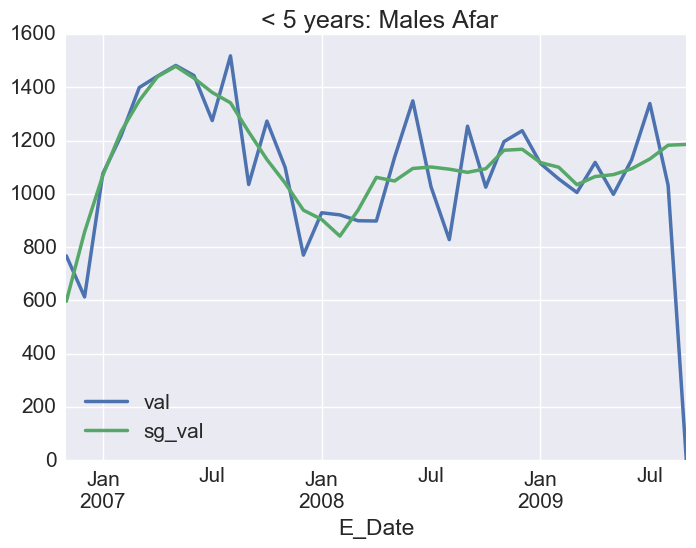

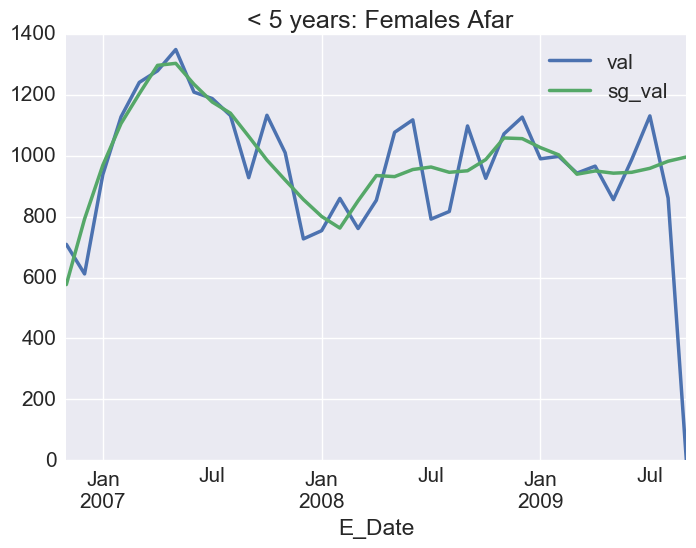

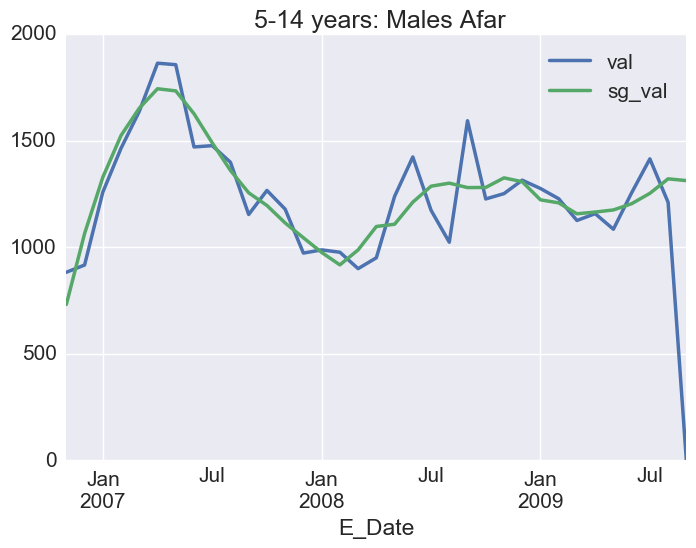

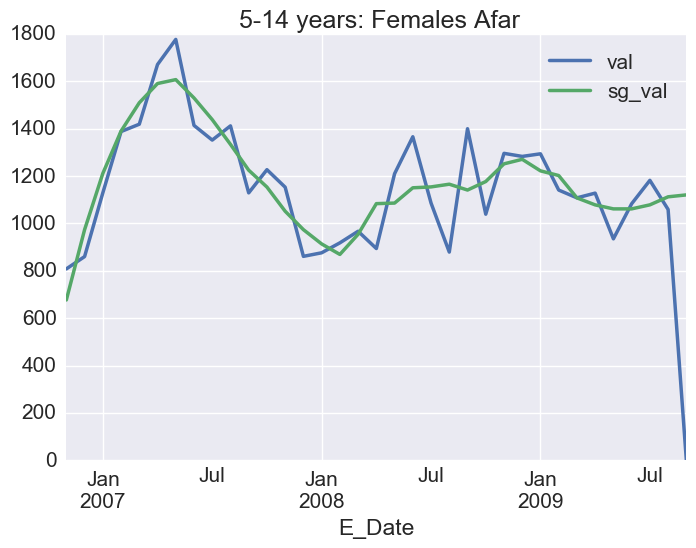

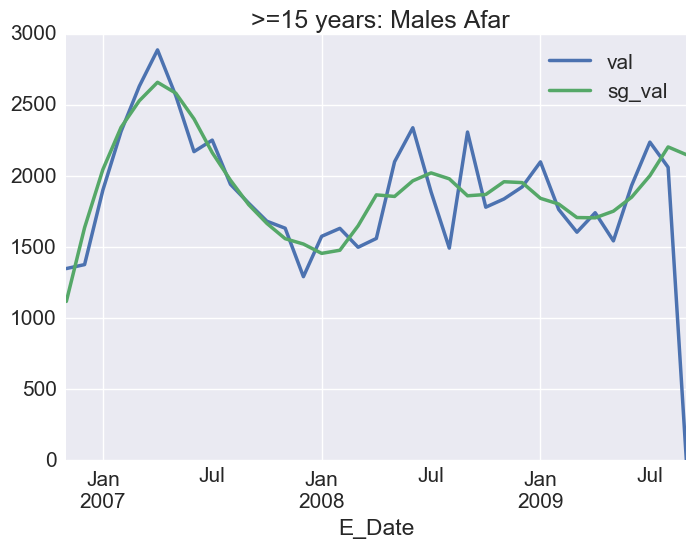

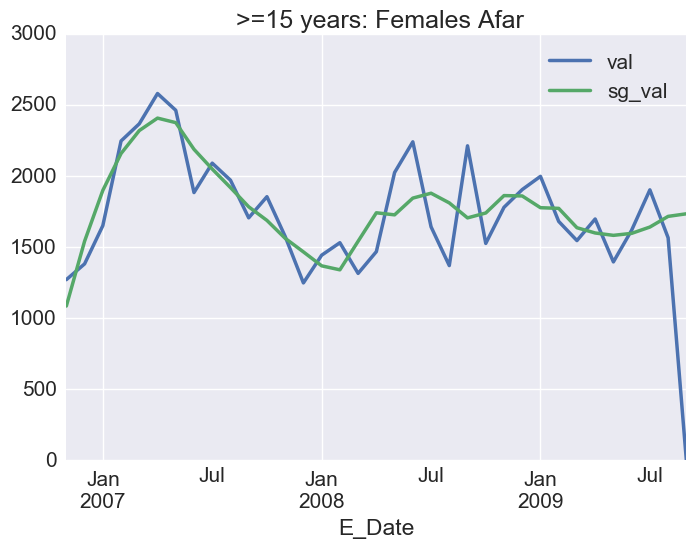

In [61]:
savedir = 'SG_filter'
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# Limit to one region in the notebook.
for region in regions[:1]:
    for indicator in malaria_indicators:
        ind_data = DF_ind_malaria[(DF_ind_malaria['Region'] == region) & (DF_ind_malaria['Indicator'] == indicator)]
        ind_data.set_index('E_Date')[['val', 'sg_val']].plot()
        plt.title('%s %s' % (indicator.split('malaria')[-1], region.title()))
        plt.savefig('%s/spline_%s_%s.png' % (savedir, region, indicator))

<h1> Add log10 of value </h1>

In [53]:
DF_ind_malaria['log_val'] = [np.log10(val+1) for val in DF_ind_malaria['val']]
DF_ind_malaria['log_sg_val'] = [np.log10(sg_val+1) for sg_val in DF_ind_malaria['sg_val']]

<h1> Save dataframe to csv - only indicators with malaria counts </h1>

In [54]:
DF_ind_malaria.to_csv('Malaria_regional_5-31-2017.csv')

<h1> DONE </h1>

<h1> Exploratory figures </h1>

<h1> Plot correlation matrix </h1>

In [173]:
def setup_prediction_interval(dataframe, months=1):
    cols_to_shift = ['val', 'log_val', 'sg_val', 'log_sg_val', 'infection_rate', 'Region', 'Indicator']
    for i in range(1, 3 + months):
        suffixes = ('', '_shift_%s' % i)
        dataframe = dataframe.merge(dataframe[cols_to_shift].shift(i), left_index=True, right_index=True, how='left', suffixes=suffixes)

    return dataframe[(dataframe['Region'] == dataframe['Region_shift_%s' % i]) & \
                    (dataframe['Indicator'] == dataframe['Indicator_shift_%s' % i])]

# Add value shifts to the dataframe
DF_ind_malaria = setup_prediction_interval(DF_ind_malaria)

In [253]:
# Get column names for the correlation matrix.
shift_range = range(0, 4)
# 'val', 'sg_val', 
SHIFT_COLUMNS = ['precipitation', 'days_precipitation', 'wind_avg', 'temp_min', 'temp_max', \
               'humid_avg', 'solar']
COLS_SHIFTED = []
for column in SHIFT_COLUMNS:
    COLS_SHIFTED += ['%s_shift_%s' % (column, i) if i >0 else column for i in shift_range]
if 'val' in COLS_SHIFTED:
    COLS_SHIFTED.remove('val')


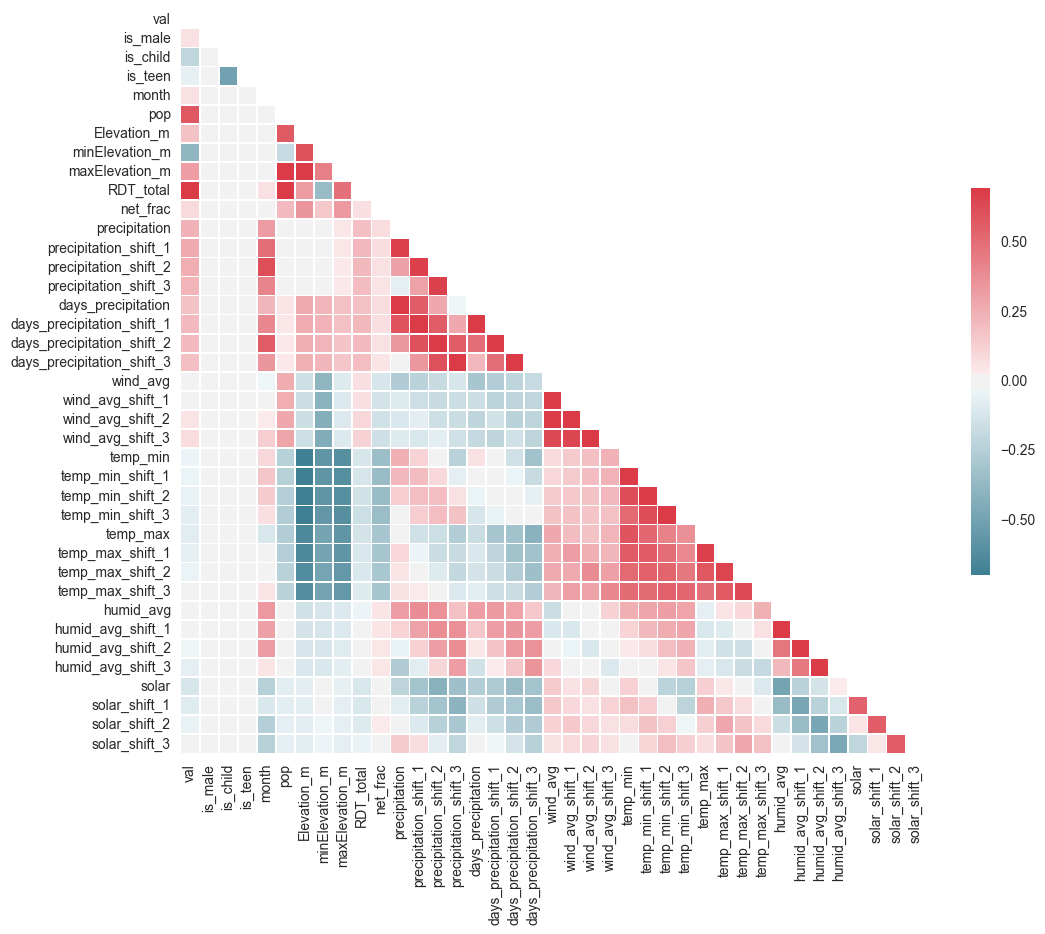

In [254]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corr_plot(corr):
    sns.set(style="white")
    # Generate a mask for the upper triangle,
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figur
    f, ax = plt.subplots(figsize=(12, 10))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    
#for region in DF_ind['Region'].unique():
    # Only select indicators relavent to malaria (no composite indicators)
COLS_TO_PLOT = ['is_male', 'is_child', 'is_teen', 'month', 'pop', 'Elevation_m', 'minElevation_m', \
                'maxElevation_m', 'RDT_total', 'net_frac']
corr_plot(DF_ind_malaria[['val'] + COLS_TO_PLOT + COLS_SHIFTED].corr(method='spearman'))

<h1> View correlations to the malaria value </h1>

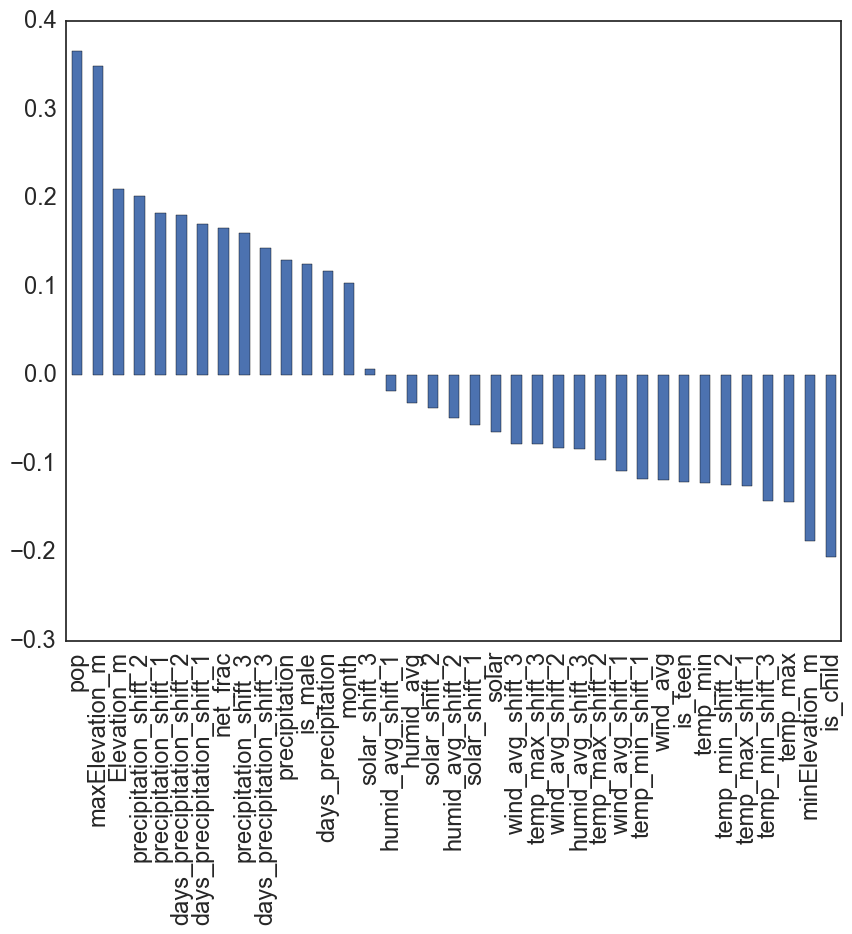

In [257]:
DF_ind_malaria[['val'] + COLS_TO_PLOT + COLS_SHIFTED].corr().val.sort_values(ascending=False)[2:].plot\
        .bar(figsize=(10,8),fontsize=17)

<h1> view elevation distribution by age/gender </h1>

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


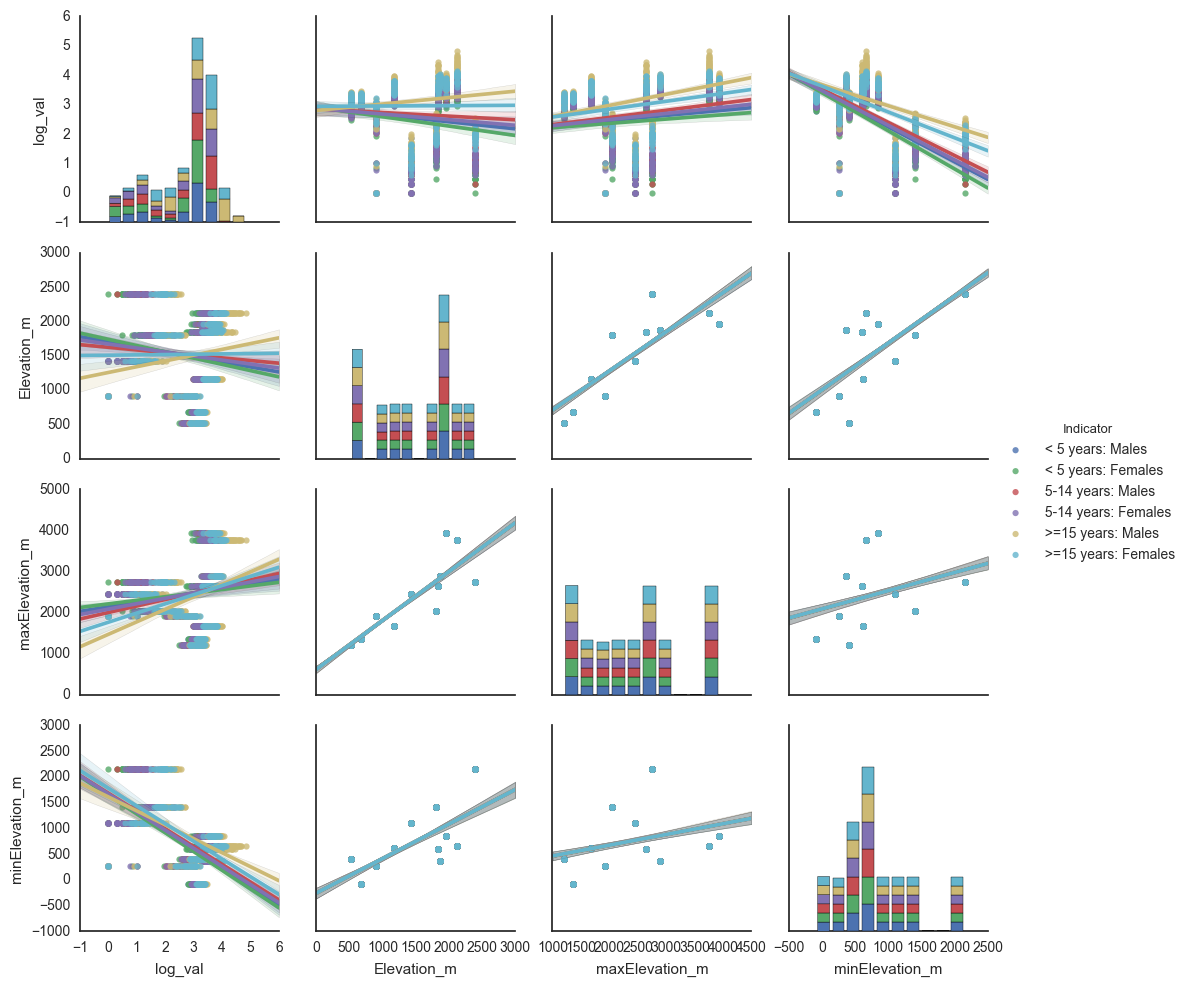

In [25]:
elevation_cols = ['log_val', 'Elevation_m', 'maxElevation_m', 'minElevation_m', 'Region', 'Indicator']
elv_data = DF_ind_malaria[elevation_cols]
elv_data['Indicator'] = [name.split('malaria')[-1] for name in elv_data['Indicator']]

g = sns.pairplot(elv_data, hue='Indicator', kind='reg')

<h1> plot only one row </h1>

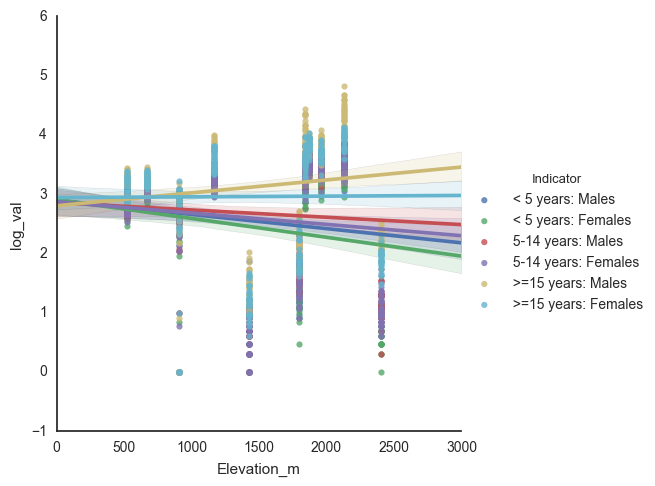

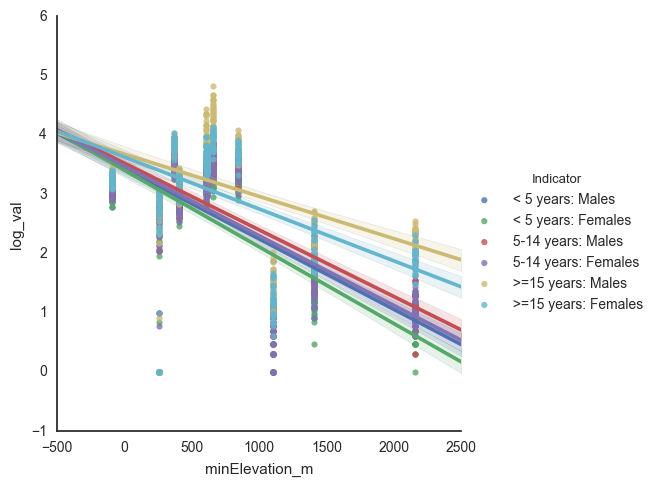

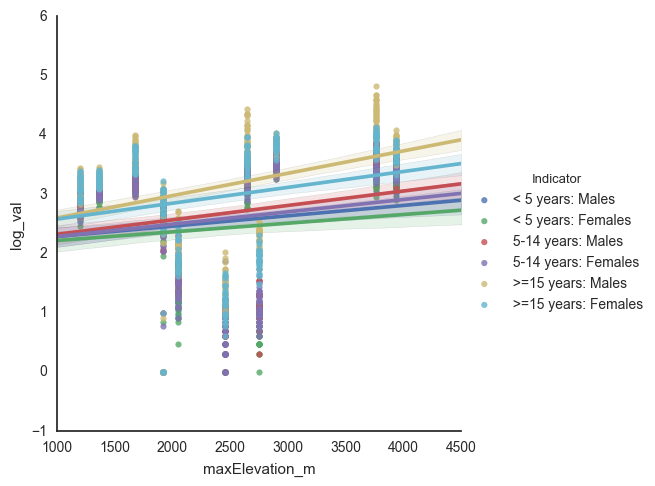

In [206]:
#fig, axs = plt.subplots(ncols=3)
sns.lmplot(x='Elevation_m', y='log_val', hue='Indicator', data=elv_data)
sns.lmplot(x='minElevation_m', y='log_val', hue='Indicator', data=elv_data)
sns.lmplot(x='maxElevation_m', y='log_val', hue='Indicator', data=elv_data)

<h1> view by region </h1>

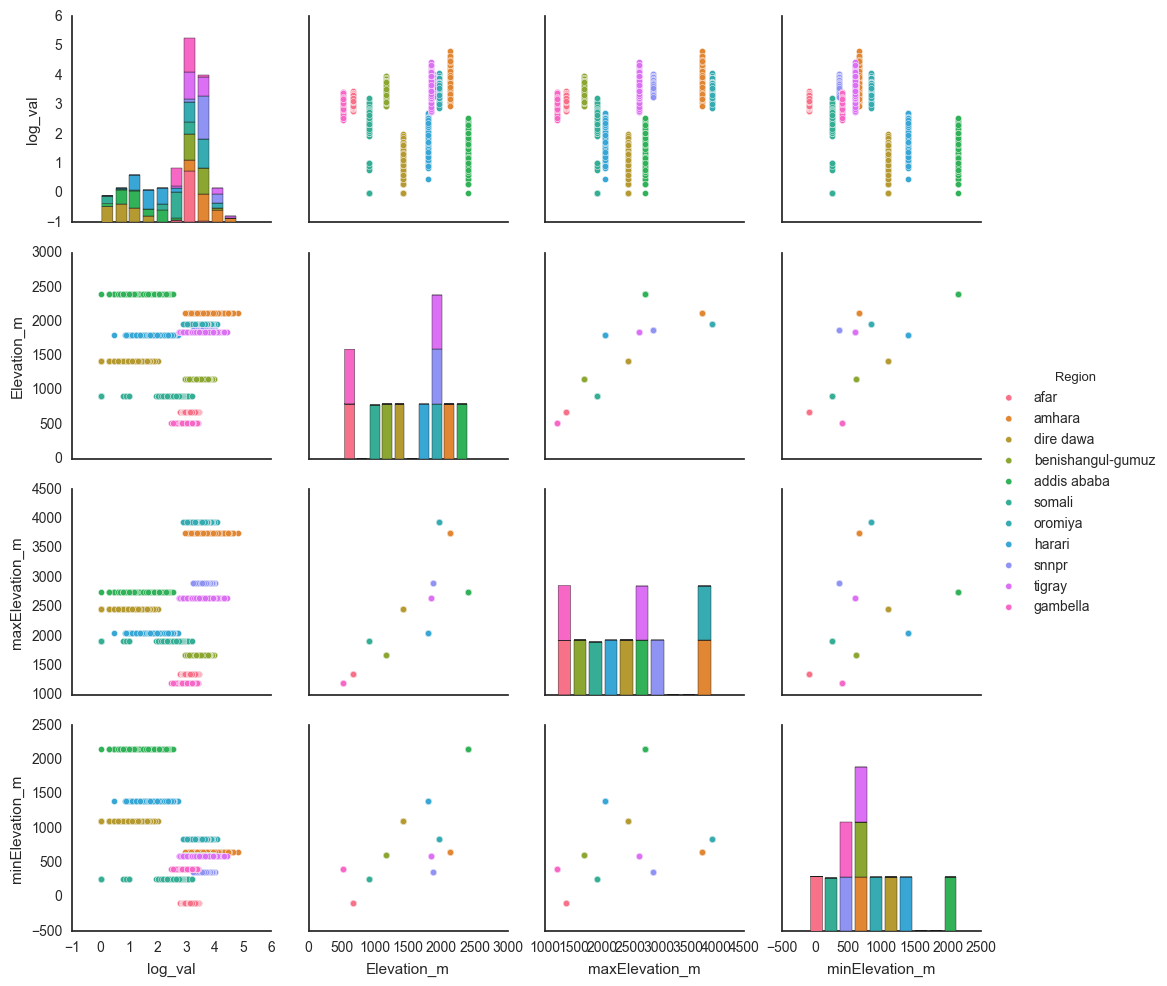

In [123]:
elevation_cols = ['log_val', 'Elevation_m', 'maxElevation_m', 'minElevation_m', 'Region', 'Indicator']
elv_data = DF_ind_malaria[elevation_cols]

g = sns.pairplot(elv_data, hue='Region', kind='scatter')

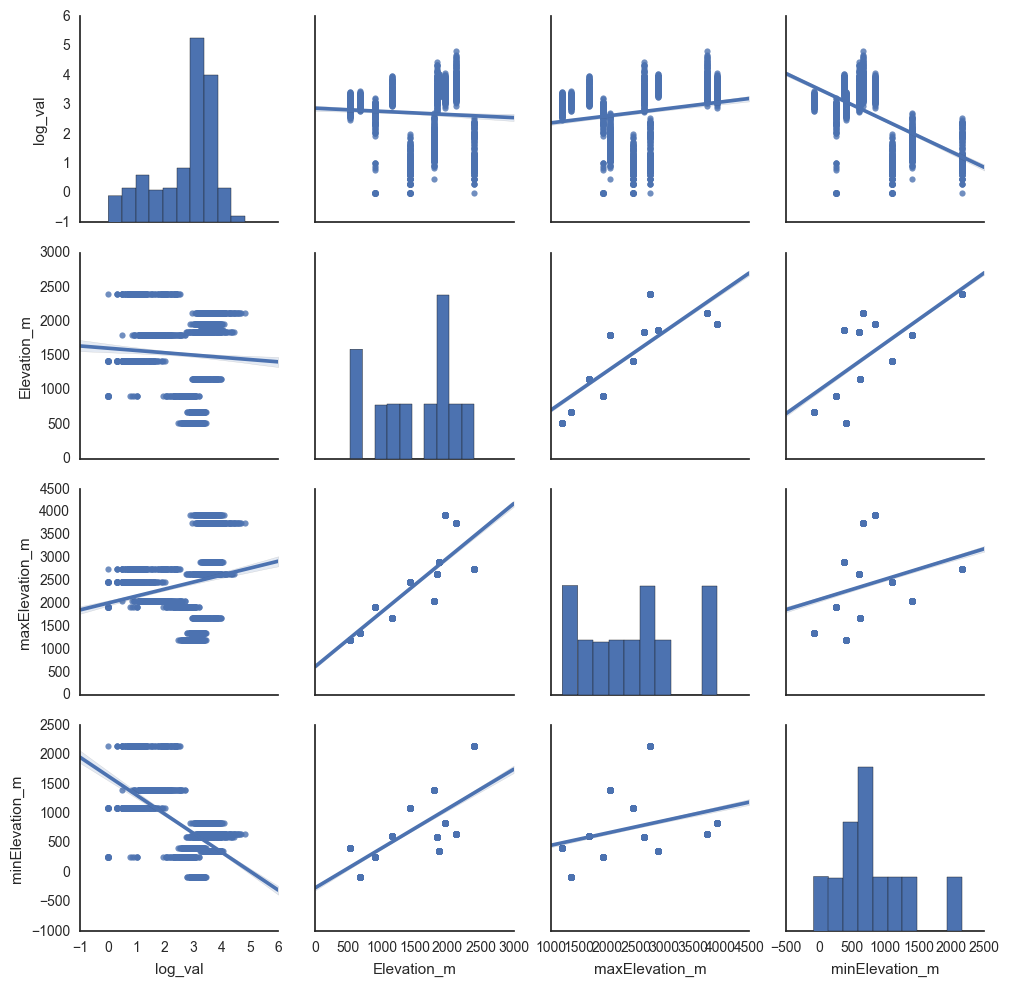

In [207]:
g = sns.pairplot(elv_data, kind="reg")

<h1> View correlation with weather </h1>

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


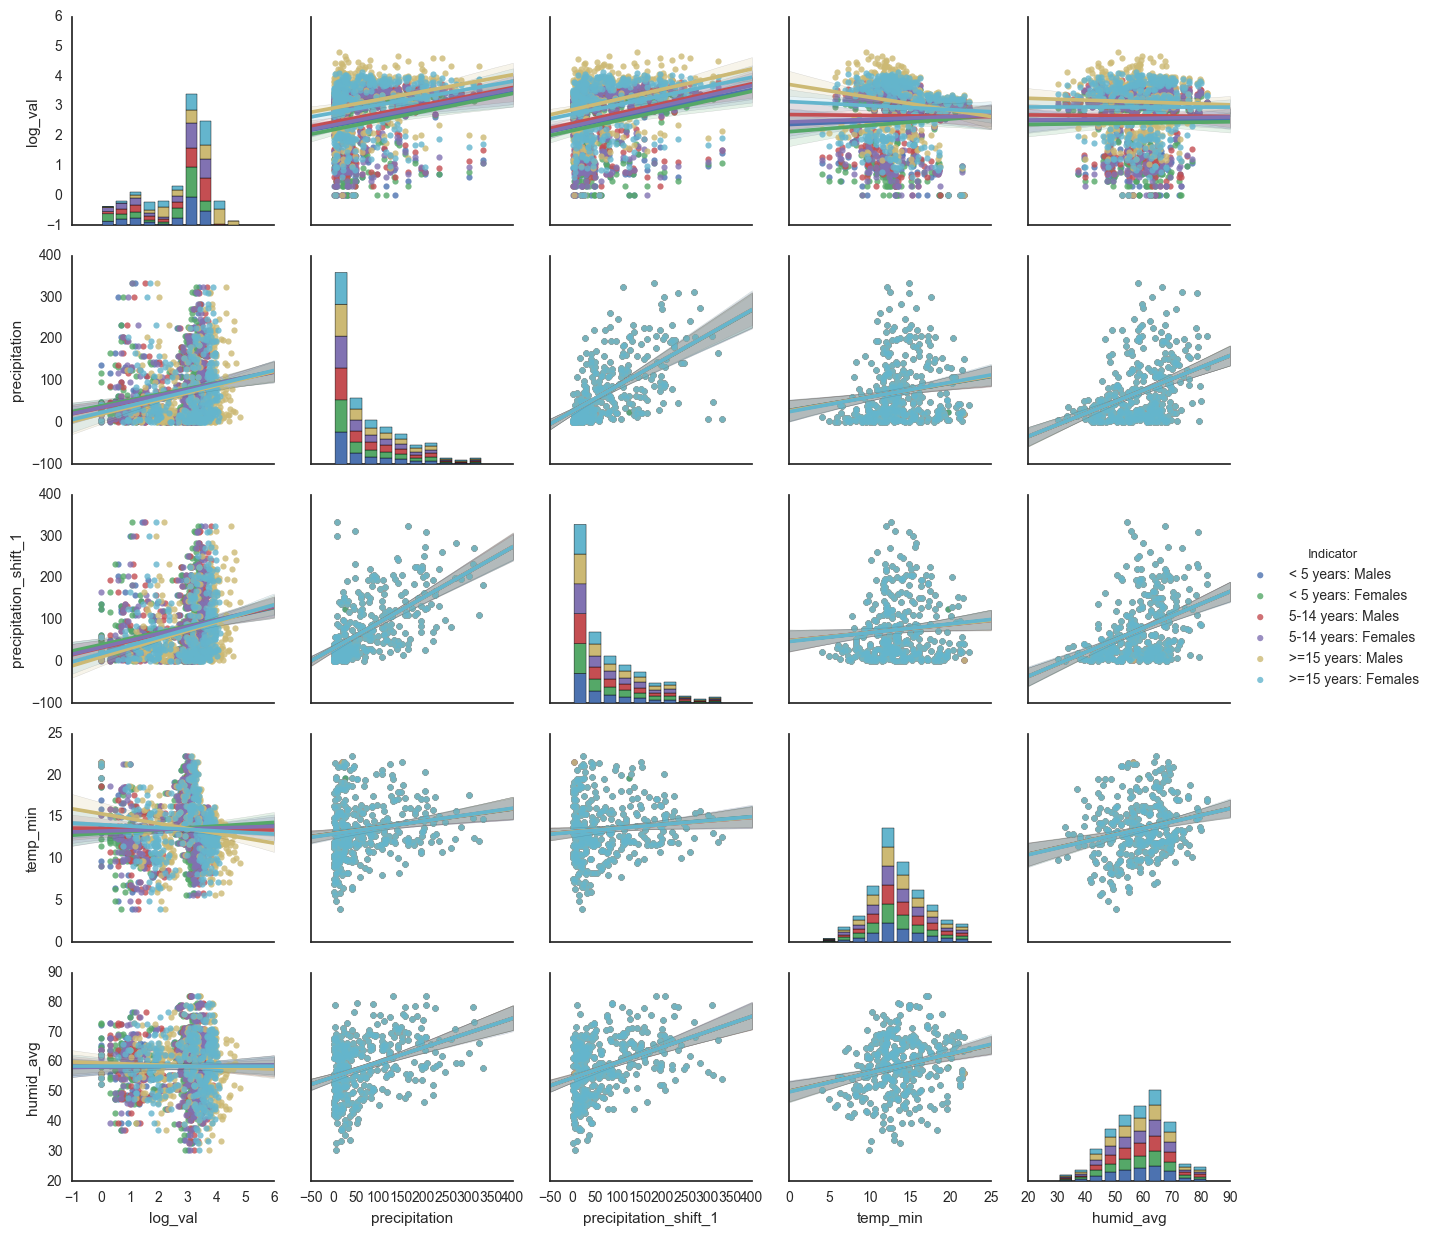

In [34]:
weather_cols = ['log_val', 'precipitation', 'precipitation_shift_1', 'temp_min', 'humid_avg', 'Region', 'Indicator']
weather_cut = DF_ind_malaria[weather_cols]
weather_cut['Indicator'] = [name.split('malaria')[-1] for name in weather_cut['Indicator']]

g = sns.pairplot(weather_cut, hue='Indicator', kind='reg')

<h1> weather correlations </h1>

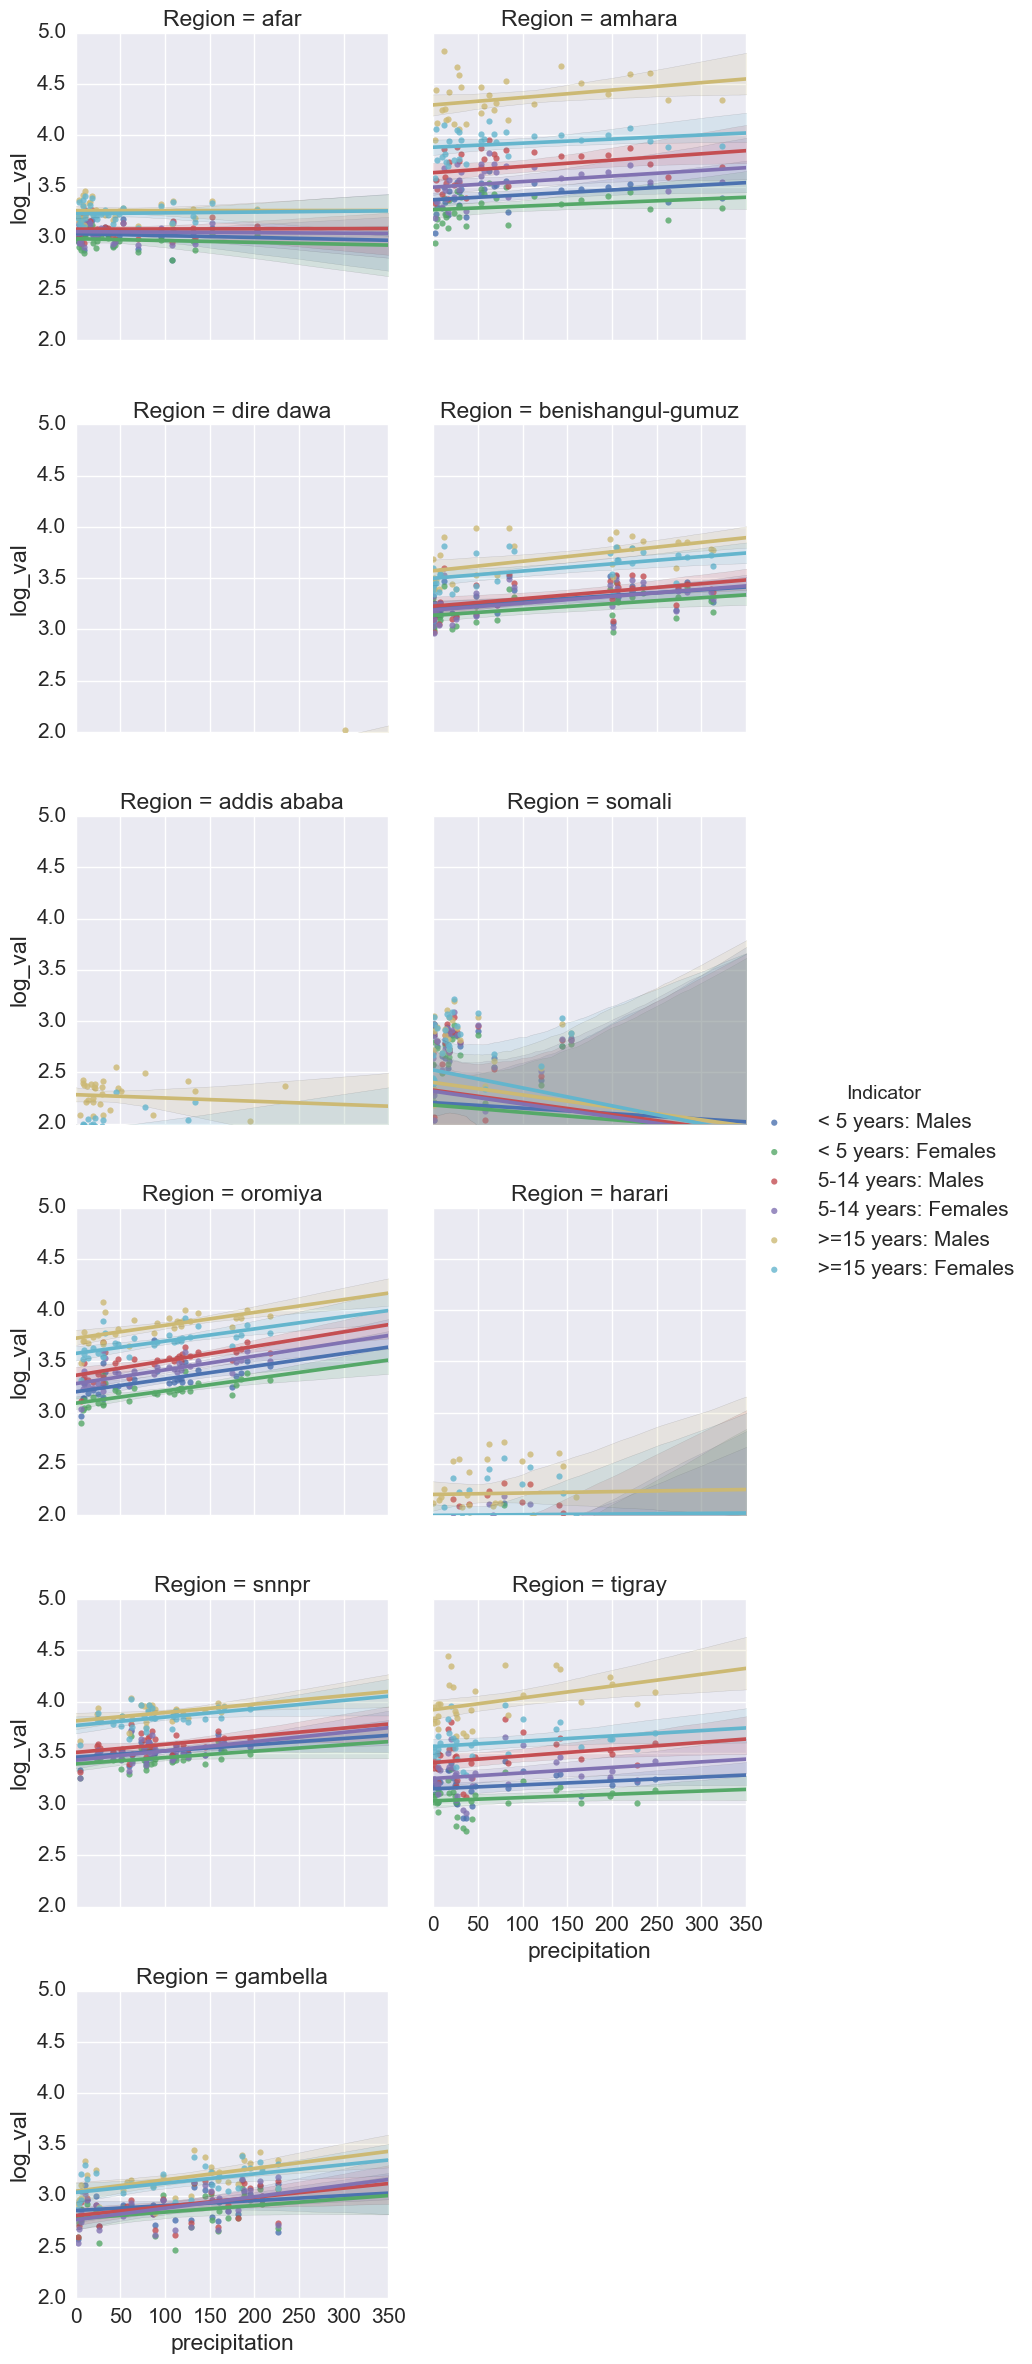

In [56]:
sns.set(font_scale=1.5)
sns.lmplot(x='precipitation', y='log_val',  col='Region', hue='Indicator', data=weather_cut, col_wrap=3, size=4)\
.set(ylim=(0, 5), xlim=(0, 350))

#sns.lmplot(x='humid_avg', y='log_val', col='Region', hue='Indicator', data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))
#sns.lmplot(x='temp_min', y='log_val', col='Region', hue='Indicator', data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

<h1> decompose correlations with precipitations  for all regions for each indicator</h1>

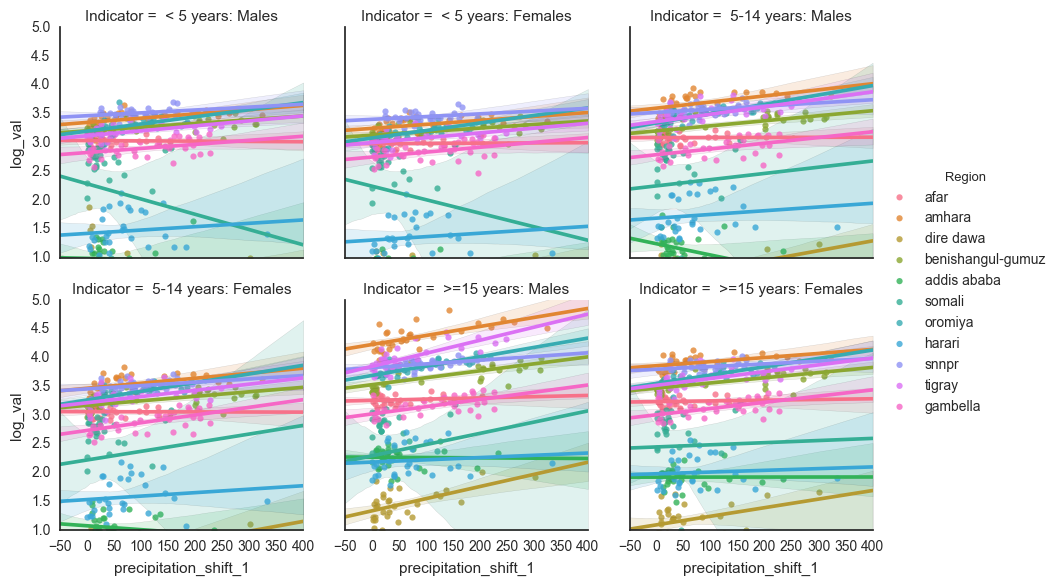

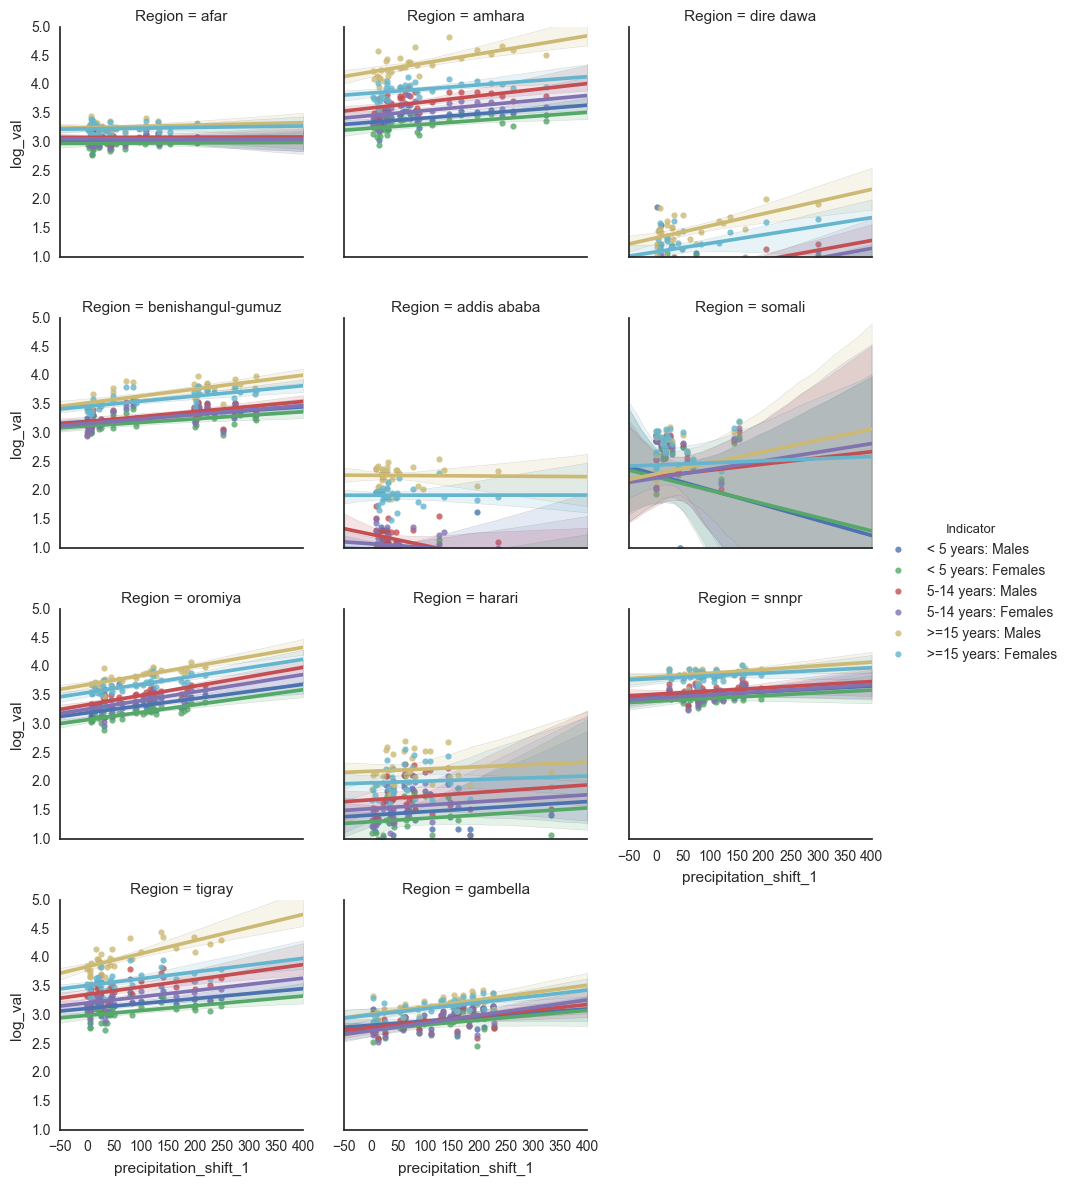

In [30]:
g = sns.lmplot(x='precipitation_shift_1', y='log_val', col='Indicator', hue='Region', \
               data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

g = sns.lmplot(x='precipitation_shift_1', y='log_val', col='Region', hue='Indicator', \
               data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

<h1> Impact of temperature for each region</h1>

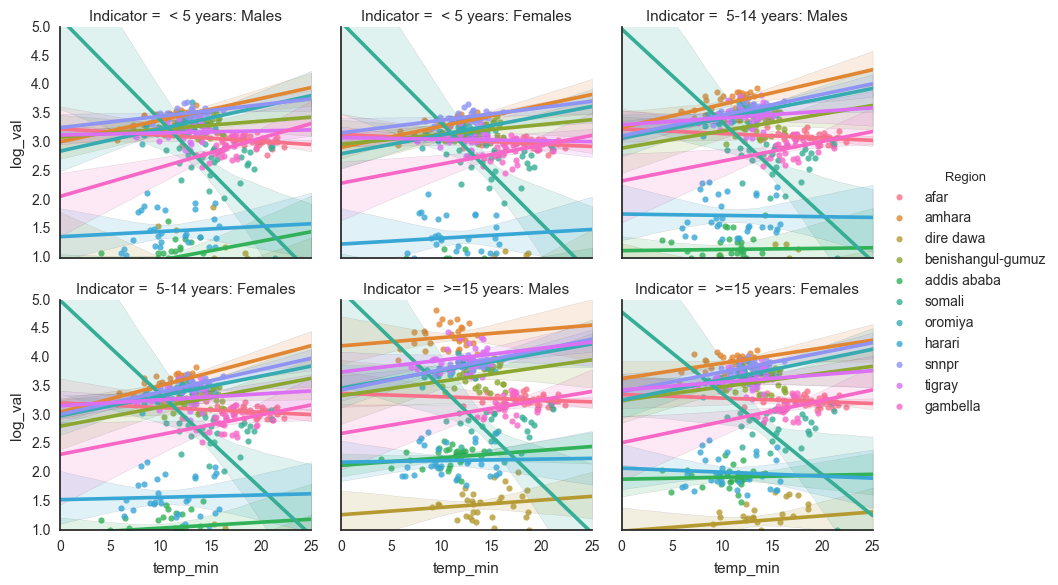

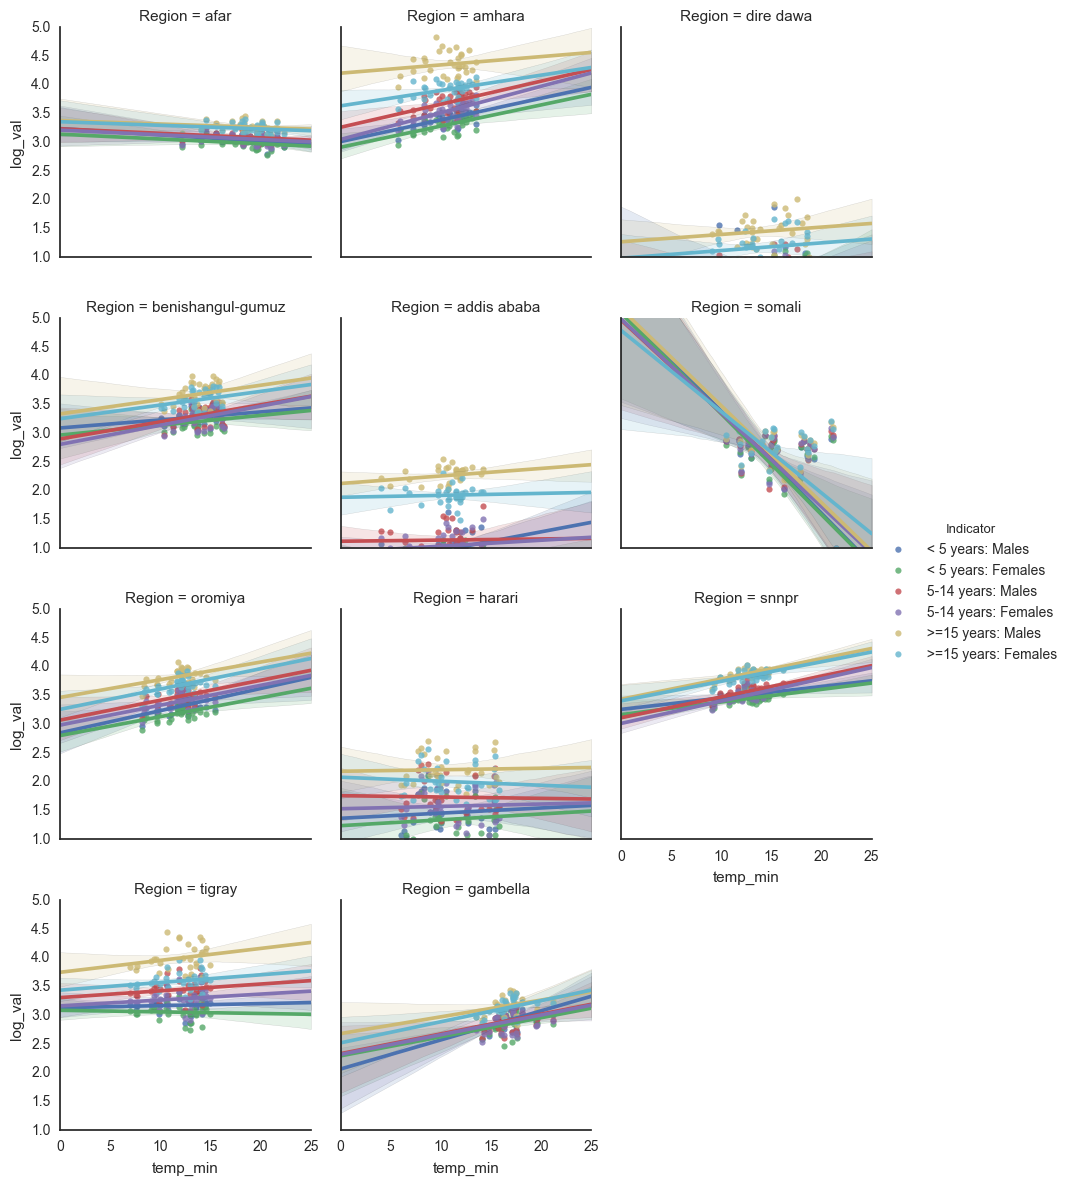

In [35]:
g = sns.lmplot(x='temp_min', y='log_val', col='Indicator', hue='Region', \
               data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

g = sns.lmplot(x='temp_min', y='log_val', col='Region', hue='Indicator', \
               data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

<h1> view precipitation and temperature </h1>

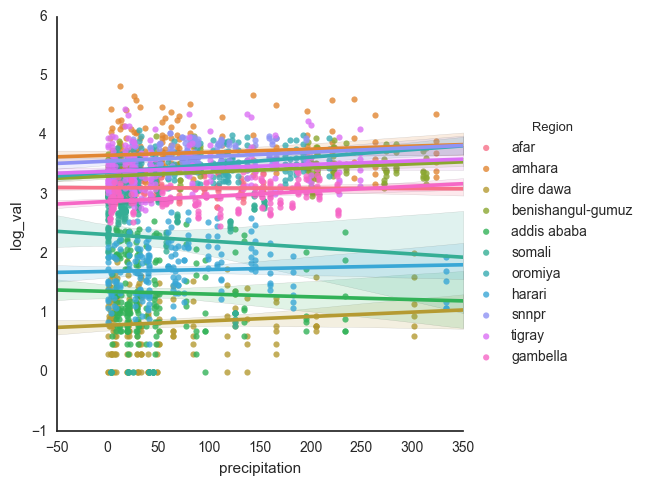

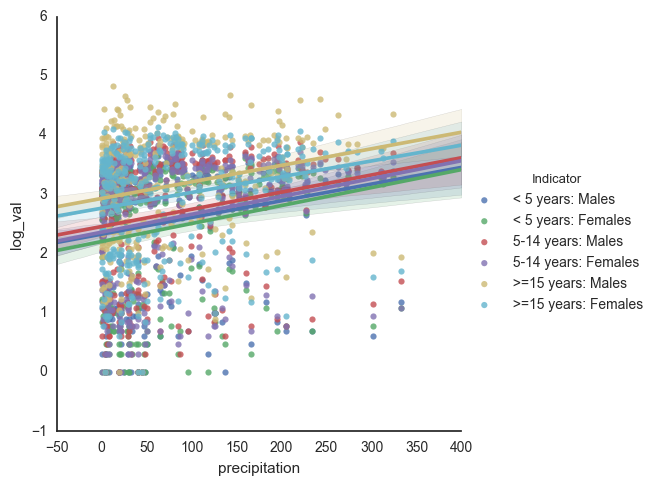

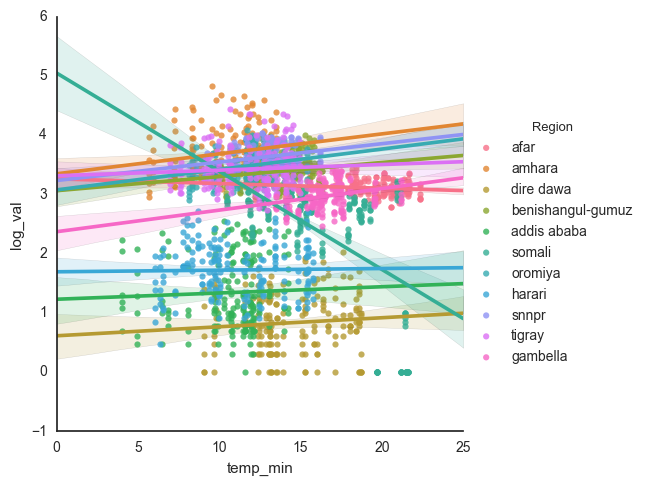

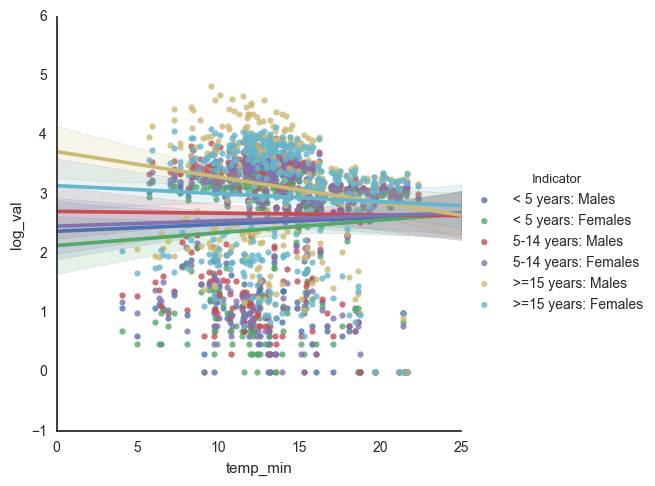

In [36]:
sns.lmplot(x='precipitation', y='log_val', hue='Region', data=weather_cut)
sns.lmplot(x='precipitation', y='log_val', hue='Indicator', data=weather_cut)

sns.lmplot(x='temp_min', y='log_val', hue='Region', data=weather_cut)
sns.lmplot(x='temp_min', y='log_val', hue='Indicator', data=weather_cut)
